# Plot 2: flops vs BD-rate

In [11]:
import pandas as pd
import seaborn as sns

from coolchic.eval.hypernet import get_hypernet_flops
from coolchic.hypernet.hypernet import DeltaWholeNet, NOWholeNet

sns.set_theme(context="notebook", style="whitegrid")

In [4]:
flops = {
    "coolchic": (
        coolchic_fwd := get_hypernet_flops(DeltaWholeNet, get_coolchic_flops=True)
    ),
    "coolchic_step": 3 * coolchic_fwd,
    "nocc": get_hypernet_flops(NOWholeNet),
    "delta": get_hypernet_flops(DeltaWholeNet),
}

bd_rates = {
    "kodak": {
        "nocc": 33.478488207355284,
        "delta": 33.478488207355284,
    },
    "clic20-pro-valid": {
        "nocc": 36.233904571367106,
        "delta": 28.284958907776783,
    },
}

In [ ]:
df2 = pd.DataFrame(
    [
        (dataset, method, bd_rate, flops[method])
        for dataset, bd_rates in bd_rates.items()
        for method, bd_rate in bd_rates.items()
    ],
    columns=["dataset", "method", "bd_rate", "flops"],
)
df2["num_coolchic_steps"] = df2["flops"] / flops["coolchic_step"]
df2.head()

,dataset,method,bd_rate,flops,num_coolchic_steps
0,kodak,nocc,33.478488,38908956672,22.208348
1,kodak,delta,33.478488,48419218432,27.636589
2,clic20-pro-valid,nocc,36.233905,38908956672,22.208348
3,clic20-pro-valid,delta,28.284959,48419218432,27.636589


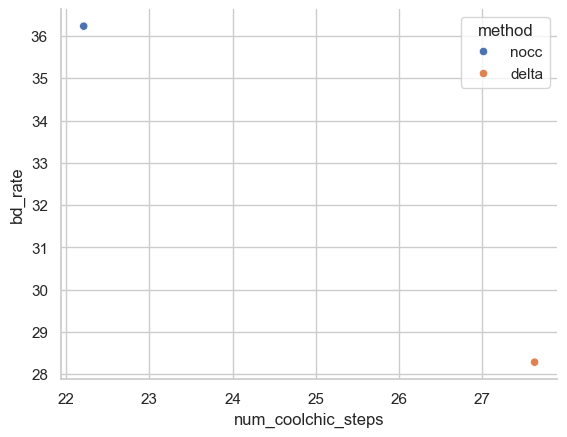

In [19]:
sns.scatterplot(
    data=df2[df2["dataset"] == "clic20-pro-valid"],
    x="num_coolchic_steps",
    y="bd_rate",
    hue="method",
)
sns.despine()